In [1]:
%load_ext autoreload
%autoreload 2

# Spark Preprocessing

In [1]:
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.getOrCreate()
df = spark.read.parquet("../data/processed/enwiki-meta-compact")
df.createOrReplaceTempView("enwiki")

In [2]:
def get_edges(period):
    query = """
    with subset as (
        SELECT
            concat(year, '-', quarter) as period,
            article_id,
            cast(user_id as int) as user_id,
            textdata
        FROM
            enwiki
    )
    -- collect the weighted edge-list
    SELECT
        user_id,
        article_id,
        sum(textdata) as word_count,
        count(*) as num_edits 
    FROM
        subset
    WHERE
        subset.user_id is not null AND
        period = '{}'
    GROUP BY 1, 2
    """.format(period)

    res = spark.sql(query)
    return res

%time get_edges('2002-1').show(n=5)

+-------+----------+----------+---------+
|user_id|article_id|word_count|num_edits|
+-------+----------+----------+---------+
|     62|     31429|      1317|        3|
|      4|     11701|       140|        1|
|     66|     34340|       352|        1|
|      2|      7655|       531|        1|
|    188|     64109|       124|        1|
+-------+----------+----------+---------+
only showing top 5 rows

CPU times: user 2.6 ms, sys: 7.17 ms, total: 9.77 ms
Wall time: 14.4 s


In [35]:
edges_df = get_edges('2007-1')
edges_df.cache()
edges_df.createOrReplaceTempView("edges")
print(edges_df.count())
edges_df.show(n=5)

4694179
+-------+----------+----------+---------+
|user_id|article_id|word_count|num_edits|
+-------+----------+----------+---------+
| 239028|    618219|       509|        1|
|1087617|   5561815|       202|        1|
|2489796|   7823005|    100758|       48|
| 643861|   7720015|       167|        2|
| 789390|    284325|      1864|        1|
+-------+----------+----------+---------+
only showing top 5 rows



In [36]:
user_count = edges_df.select("user_id").distinct().count()
user_count

354500

In [7]:
edges_df.where("num_edits > 1").select("user_id").distinct().count()

196368

In [8]:
edges_df.select("article_id").distinct().count()

1291873

Remove all nodes with `degree = 1` and where the number of shared articles is greater than 1.

In [14]:
def project_common_neighbors(edges, threshold):
    edges.createOrReplaceTempView("edges")
    query = """
    with unimodal_projection as (
        SELECT
            t1.user_id as e1,
            t2.user_id as e2,
            count(*) as shared_articles
        FROM edges t1
        JOIN edges t2 ON t1.article_id = t2.article_id
        WHERE t1.user_id < t2.user_id
        GROUP BY 1, 2
    )

    SELECT e1, e2, shared_articles
    FROM unimodal_projection
    WHERE shared_articles > {}
    """.format(threshold)
    return spark.sql(query)
    

%time print(project_common_neighbors(edges_df, 1).count())

3779272
CPU times: user 5.47 ms, sys: 12.3 ms, total: 17.8 ms
Wall time: 35.8 s


In [37]:
import os

elist = project_common_neighbors(edges_df, 0)

path = "../data/interim/2007Q1-user-network-v1"
elist.select("e1", "e2").coalesce(1).write.csv(path, sep='\t')
os.system("mv {0}/*.csv {0}.csv && rm -r {0}".format(path))

0

In [39]:
!head -n5 "../data/interim/2007Q1-user-network-v1.csv"

6995	293836
982822	3309840
218757	433328
33566	3828001
363815	516856


In [13]:
import numpy as np
import pyspark.sql.functions as F

elist.cache()

res = []
for i in range(0, 20):
    threshed = elist.where(F.col("shared_articles") > i)
    e1 = threshed.selectExpr("e1 as nodes").distinct()
    e2 = threshed.selectExpr("e2 as nodes").distinct()
    nodes = e1.union(e2).distinct().count()
    edges = threshed.count()
    res.append((i, nodes, edges))

elist.unpersist()

print(res)

[(0, 344379, 29473902), (1, 115699, 3779272), (2, 63390, 1688425), (3, 43815, 1031248), (4, 33896, 720445), (5, 27785, 543160), (6, 23816, 429896), (7, 21013, 352194), (8, 18915, 295729), (9, 17197, 252971), (10, 15840, 219787), (11, 14655, 193441), (12, 13687, 172009), (13, 12815, 154293), (14, 12083, 139421), (15, 11405, 126689), (16, 10840, 115801), (17, 10308, 106445), (18, 9810, 98302), (19, 9409, 91176)]


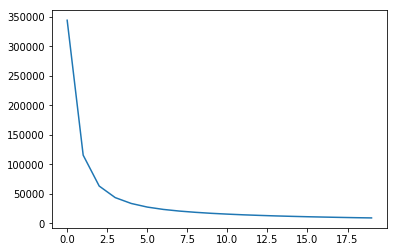

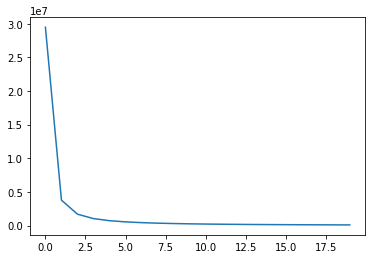

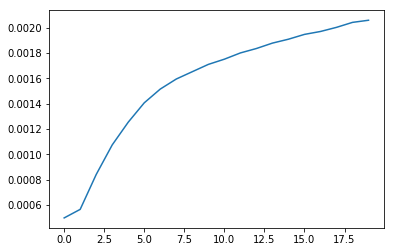

In [28]:
import matplotlib.pyplot as plt
from functools import partial

thresh, n_nodes, n_edges = zip(*res)
plt.plot(thresh, n_nodes)
plt.show()

plt.plot(thresh, n_edges)
plt.show()

def density(nodes, edges):
    total = nodes*(nodes-1)/2
    return (1.0*edges)/total

# not very useful
plt.plot(thresh, map(lambda x: density(*x), zip(n_nodes, n_edges)))
plt.show()

In [18]:
def get_edges_blocked(period):
    query = """
    with subset as (
        SELECT
            concat(year, '-', quarter) as period,
            dayofyear(timestamp) as doy,
            article_id,
            cast(user_id as int) as user_id,
            textdata
        FROM
            enwiki
    )
    -- collect the weighted edge-list
    SELECT
        user_id,
        article_id,
        doy,
        sum(textdata) as word_count,
        count(*) as num_edits 
    FROM
        subset
    WHERE
        subset.user_id is not null AND
        period = '{}'
    GROUP BY 1, 2, 3
    """.format(period)

    return spark.sql(query)


def project_common_neighbors_by_day(edges, threshold):
    edges.createOrReplaceTempView("edges")
    query = """
    with unimodal_projection as (
        SELECT
            t1.user_id as e1,
            t2.user_id as e2,
            count(*) as shared_articles
        FROM edges t1
        JOIN edges t2 
        ON t1.article_id = t2.article_id AND t1.doy = t2.doy
        WHERE t1.user_id < t2.user_id
        GROUP BY 1, 2
    )

    SELECT e1, e2, shared_articles
    FROM unimodal_projection
    WHERE shared_articles > {}
    """.format(threshold)
    return spark.sql(query)
    

edge_blocked = get_edges_blocked("2007-1")
elist_day = project_common_neighbors_by_day(edge_blocked, 0)
elist_day.cache()
elist_day.count()

1825594

In [27]:
!ls ../data/interim/

2007-1-enwiki-projection-roles.csv  agm_2007Q1_1000.csv  enwiki-meta-parquet
2007Q1-edges-v1.csv		    agm_2007Q1_100.csv	 role-2007-1
2007Q1-user-network-v1.csv	    agm_2007Q1_200.csv	 role-2007-2
2007Q1-user-network-v2.csv	    agm_2007Q1_500.csv	 role-2007-3
agm				    agm_2007Q1_50.csv	 role-2007-4


In [31]:
import os
path = "../data/interim/2007Q1-user-network-v2"
elist_day.select("e1", "e2").coalesce(1).write.csv(path, sep='\t')

os.system("mv {0}/*.csv {0}.csv && rm -r {0}".format(path))

0

In [32]:
!head -n5 ../data/interim/2007Q1-user-network-v2.csv

411035	2372661
238968	372343
297629	2287529
433328	1915965
94147	416594


In [19]:
res_day = []
for i in range(0, 20):
    threshed = elist_day.where(F.col("shared_articles") > i)
    e1 = threshed.selectExpr("e1 as nodes").distinct()
    e2 = threshed.selectExpr("e2 as nodes").distinct()
    nodes = e1.union(e2).distinct().count()
    edges = threshed.select("e1", "e2").distinct().count()
    res_day.append((i, nodes, edges))

res_day

[(0, 212654, 1825594),
 (1, 46451, 213195),
 (2, 23149, 88016),
 (3, 15282, 50116),
 (4, 11449, 33105),
 (5, 9156, 23882),
 (6, 7563, 18217),
 (7, 6451, 14468),
 (8, 5598, 11825),
 (9, 4930, 9844),
 (10, 4395, 8412),
 (11, 3964, 7266),
 (12, 3569, 6251),
 (13, 3260, 5500),
 (14, 2928, 4810),
 (15, 2709, 4328),
 (16, 2521, 3893),
 (17, 2339, 3533),
 (18, 2178, 3207),
 (19, 2025, 2905)]

In [ ]:
thresh, n_nodes, n_edges = zip(*res)
plt.plot(thresh, n_nodes)
plt.show()

plt.plot(thresh, n_edges)
plt.show()

In [6]:
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors, VectorUDT
from functools import partial

def to_sparse(size, arr):
    return Vectors.sparse(size, {idx: 1.0 for idx in arr})
    

n_articles = edges_df.selectExpr("max(article_id) as n_articles").collect()[0].n_articles + 1
sparse_udf = F.udf(partial(to_sparse, n_articles), VectorUDT())

user_article = (
    edges_df
    .groupby("user_id")
    .agg(F.collect_set("article_id").alias("article_set"))
    .withColumn("article_set", sparse_udf("article_set"))
)

mh = MinHashLSH(inputCol="article_set", outputCol="hashes", numHashTables=5)
model = mh.fit(user_article)

transformed = model.transform(user_article)
transformed.cache()

DataFrame[user_id: int, article_set: vector, hashes: array<vector>]

In [7]:
def simjoin(model, transformed, threshold=0.5):
    return (
        model.approxSimilarityJoin(transformed, transformed, threshold, distCol="JaccardDistance")
        .select(
            F.col("datasetA.user_id").alias("source"),
            F.col("datasetB.user_id").alias("dest"),
            F.col("JaccardDistance"))
        .where("source < dest")
    )

data = simjoin(model, transformed, 0.5)
data.count()

221223

In [9]:
import numpy as np

def sim_stats(data):
    e1 = data.selectExpr("source as nodes").distinct()
    e2 = data.selectExpr("dest as nodes").distinct()
    nodes = e1.union(e2).distinct().count()
    edges = data.count()
    return nodes, edges

res_sim = []
for i in np.linspace(0, 1, 11):
    data = simjoin(model, transformed, i)
    n, e = sim_stats(data)
    res_sim.append((i, n, e))

res_sim

[(0.0, 0, 0),
 (0.1, 92098, 220169),
 (0.2, 92172, 219708),
 (0.30000000000000004, 92265, 220171),
 (0.4, 93409, 221168),
 (0.5, 93546, 221042),
 (0.6000000000000001, 143766, 453561),
 (0.7000000000000001, 170424, 628656),
 (0.8, 188266, 769902),
 (0.9, 221774, 1024455),
 (1.0, 257831, 1254054)]

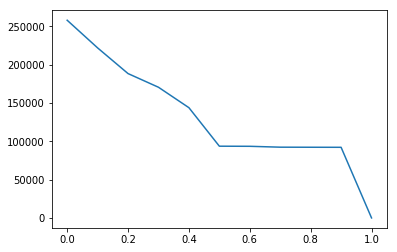

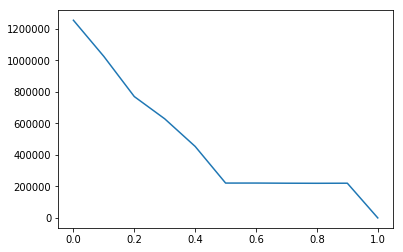

In [13]:
import matplotlib.pyplot as plt

thresh, n_nodes, n_edges = zip(*res_sim)
plt.plot(1-np.array(thresh), n_nodes)
plt.show()

plt.plot(1-np.array(thresh), n_edges)
plt.show()

# Snap processing

In [1]:
! head -n5 ../data/interim/2007Q1-edges-v1.csv

user_id,article_id,word_count,num_edits
239028,618219,509,1
1087617,5561815,202,1
2489796,7823005,100758,48
643861,7720015,167,2


In [2]:
! head -n 5 ../data/interim/2007Q1-user-network-v1.csv

3054371,516856,1
6995,293836,1
982822,3309840,1
218757,433328,6
33566,3828001,3
